You’re working on a drug discovery project, testing combinations of three compounds to create a new medicine.

Each experiment is stored in initial_inputs.npy as a 3D array, where each row lists the amounts of the three compounds used. After each experiment, you record the number of adverse reactions, stored in initial_outputs.npy as a 1D array.

Your goal is to minimise side effects; in this competition, it is framed as maximisation by optimising a transformed output (e.g. the negative of side effects). 

In [1]:
import numpy as np
import pandas as pd

In [2]:
inputs_f3 = np.load('function_3/initial_inputs.npy')
outputs_f3 = np.load('function_3/initial_outputs.npy')

In [3]:
print("Inputs (Function 3):", inputs_f3)

Inputs (Function 3): [[0.17152521 0.34391687 0.2487372 ]
 [0.24211446 0.64407427 0.27243281]
 [0.53490572 0.39850092 0.17338873]
 [0.49258141 0.61159319 0.34017639]
 [0.13462167 0.21991724 0.45820622]
 [0.34552327 0.94135983 0.26936348]
 [0.15183663 0.43999062 0.99088187]
 [0.64550284 0.39714294 0.91977134]
 [0.74691195 0.28419631 0.22629985]
 [0.17047699 0.6970324  0.14916943]
 [0.22054934 0.29782524 0.34355534]
 [0.66601366 0.67198515 0.2462953 ]
 [0.04680895 0.23136024 0.77061759]
 [0.60009728 0.72513573 0.06608864]
 [0.96599485 0.86111969 0.56682913]]


In [4]:
print("Onputs (Function 3):", outputs_f3)

Onputs (Function 3): [-0.1121222  -0.08796286 -0.11141465 -0.03483531 -0.04800758 -0.11062091
 -0.39892551 -0.11386851 -0.13146061 -0.09418956 -0.04694741 -0.10596504
 -0.11804826 -0.03637783 -0.05675837]


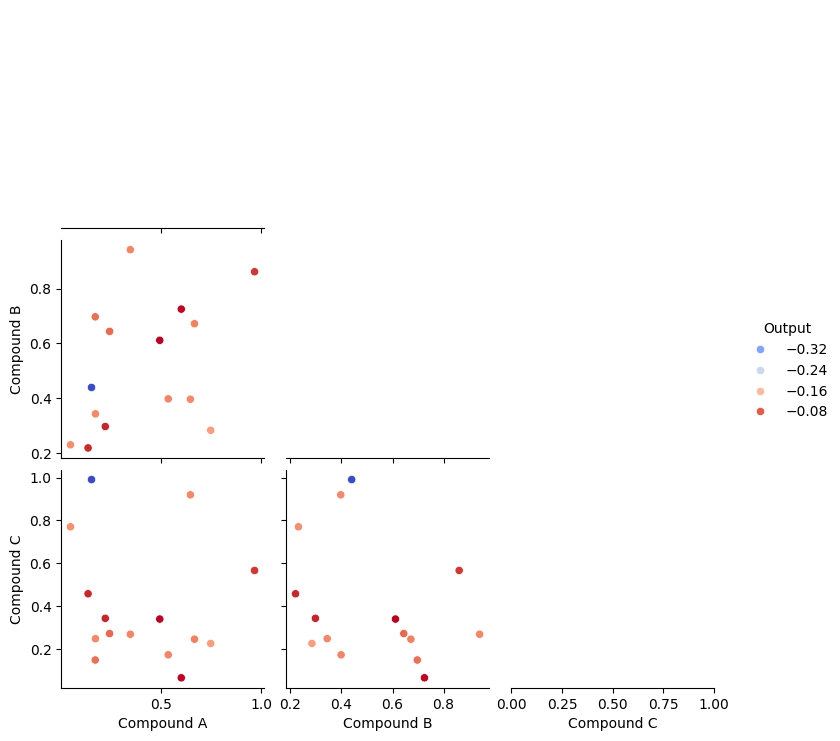

In [6]:
import seaborn as sns
df = pd.DataFrame(inputs_f3, columns=['Compound A','Compound B','Compound C'])
df['Output'] = outputs_f3

sns.pairplot(df, hue='Output', palette='coolwarm', corner=True)

Best Points

This will be the current exploitation target

In 3D, plotting it requires 3D scatter:

In [7]:
import matplotlib.pyplot as plt
import numpy as np

idx_best = np.argmax(outputs_f3)
x_best = inputs_f3[idx_best]

print("Best observed input:", x_best)
print("Best observed output:", outputs_f3[idx_best])

Best observed input: [0.49258141 0.61159319 0.34017639]
Best observed output: -0.034835313350078584


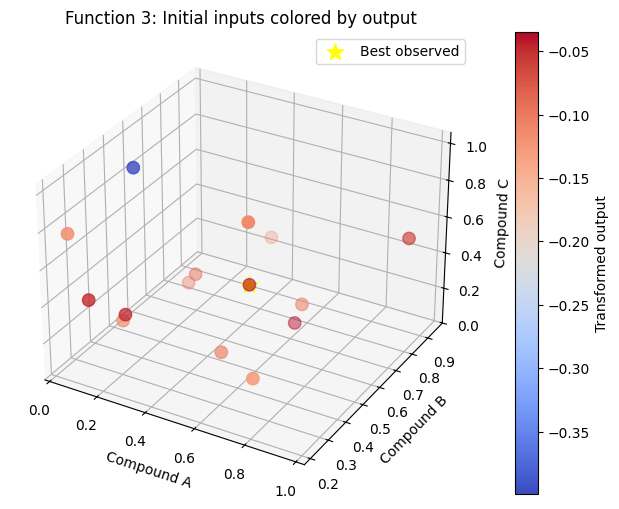

In [9]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(inputs_f3[:,0], inputs_f3[:,1], inputs_f3[:,2], c=outputs_f3, cmap='coolwarm', s=80)
ax.scatter(x_best[0], x_best[1], x_best[2], c='yellow', s=150, marker='*', label='Best observed')
fig.colorbar(sc, label='Transformed output')
ax.set_xlabel('Compound A')
ax.set_ylabel('Compound B')
ax.set_zlabel('Compound C')
ax.set_title('Function 3: Initial inputs colored by output')
ax.legend()
plt.show()

Outputs are already negative
Scale is roughly -0.4 to 0 → already suitable for GP

No log-transform needed

Implementing the gaussian process


In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-2,1.0)) \
         + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-6,1e-1))

Fit th Gaussian process

In [11]:
gp_f3 = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=10,
    random_state=42
)

gp_f3.fit(inputs_f3, outputs_f3)
print("Optimized kernel:", gp_f3.kernel_)

Optimized kernel: 1.1**2 * RBF(length_scale=0.228) + WhiteKernel(noise_level=0.0578)


In [12]:
# Create random candidate points in [0,1]^3 space (dense grid is expensive in 3D)
num_candidates = 5000
X_candidates = np.random.rand(num_candidates,3)

mu, sigma = gp_f3.predict(X_candidates, return_std=True)

kappa = 2.5
UCB = mu + kappa * sigma

idx_next = np.argmax(UCB)
x_next = X_candidates[idx_next]

print("Next point suggested by BO:", x_next)

Next point suggested by BO: [0.44786899 0.21797272 0.560485  ]


Visualization

Step 6: Exploration vs Exploitation

If x_next is close to x_best → exploitation

If x_next is far from any previous sample → exploration

In early stages with noisy outputs and sparse 3D samples, BO usually leans toward exploration due to high uncertainty.

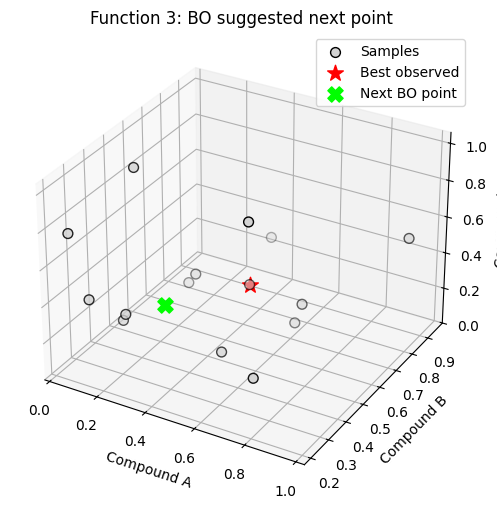

In [14]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(inputs_f3[:,0], inputs_f3[:,1], inputs_f3[:,2], c='lightgray', s=50, edgecolors='black', label='Samples')
ax.scatter(x_best[0], x_best[1], x_best[2], c='red', s=140, marker='*', label='Best observed')
ax.scatter(x_next[0], x_next[1], x_next[2], c='lime', s=120, marker='X', label='Next BO point')
ax.set_xlabel('Compound A')
ax.set_ylabel('Compound B')
ax.set_zlabel('Compound C')
ax.set_title('Function 3: BO suggested next point')
ax.legend()
plt.show()